# Unbalanced data Case Study
 Tiago Cabo, 23/Aug/2018

Context:

   Engineering Corp (EC) manufactuers widgets and during the manufacturing process they monitor 591 different sensors to try and track the quality of their production. Unfortunately, EC still has an unacceptably high failure rate. Your mission should you choose to accept it is to build a classifier that can identify which widgets are likely to fail based on the sensor data and also to identify which of the 591 sensors is most useful for doing this.

   In the data folder of this respository you will find the sensor data alongside a description of what the data contains. Once you have built your classifer then please prepare a short presentation explaining what you have done. Some things that Engineering Corp cares about are::

    1) How good is your final classifier? best result is a SVM classification model with LCA Of 400
    The cm matrix is [[405  40]
                      [ 19   7]]
    Accuracy mean: 0.9845117845117844
    Accuracy std: 0.013498912366653407
    precision score 0.14893617021276595

    2) Why did you choose the method you did?
        After grid search lenear models were best. 
        Due to an high number of features it was reduced the componentes do 400
        
    3) What is the uncertainty in your predictions?
    Accuracy mean: 0.9845117845117844
    Accuracy std: 0.013498912366653407
     meaning: 0.9711 < 0.9845 < 0.9979
     
    4) Which sensor readings are the most useful? How do you know?
    1. 439	0.007085
    2. 393	0.006535
    3. 212	0.006180
    4. 438	0.006133
    5. 425	0.005507
    This are the 5 sensors that explain more variance when considering 400 PC.
    
    5) How did you pre-process the data?
    - changes the -1 values to 0
    - Fill Nan values with the mean
    - Standarize the data in each model to reduce the impact of the magnitude of values. "Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1."
    - At the end of exercise, I have tried to over sample the dataset in order to increase accuracy and precision but with no success.
    
Future work:
    - use of xcboost
    - try other oversampling techniques.
    - Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1
    
    
    
   

## Import measurements dataset

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_curve

In [2]:
%matplotlib inline


In [3]:
# import dataset with no headers and spaces as deliminters
df = pd.read_csv('measurements.data', delimiter = ' ', header = None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [5]:
df.shape

(1567, 590)

## Independent variables


In [6]:
x = df.iloc[:, :].values


------------------------------------------------
------------------------------------------------
------------------------------------------------
## import labels dataset

In [7]:
df2 = pd.read_csv('labels.data', delimiter = ' ', header = None, names = ['success','date'])
df2.head()

,success,date
0,-1,19/07/2008 11:55:00
1,-1,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,-1,19/07/2008 14:43:00
4,-1,19/07/2008 15:22:00


### Changing -1 by 0

In [8]:
df2.success.replace([1, -1], [1, 0], inplace=True)
df2.head(5)

,success,date
0,0,19/07/2008 11:55:00
1,0,19/07/2008 12:32:00
2,1,19/07/2008 13:17:00
3,0,19/07/2008 14:43:00
4,0,19/07/2008 15:22:00


In [9]:
SuccessRate = (df2['success'].sum() / df2['success'].count()) * 100
SuccessRate
# only 6.6% of the data is successfull wich means that the data set is very unbalanced

6.636885768985322

In [10]:
df3 = pd.DataFrame(df2['success'].values, index = pd.to_datetime(df2['date']).values)
df3.tail(5)

,0
2008-10-16 15:13:00,0
2008-10-16 20:49:00,0
2008-10-17 05:26:00,0
2008-10-17 06:01:00,0
2008-10-17 06:07:00,0


In [11]:
xx = pd.to_datetime(df2['date']).values
xx
output = False

## Dependent Variable

In [12]:

y = df2.iloc[:, 0].values


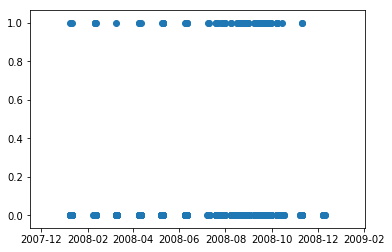

In [13]:
import matplotlib.pyplot as plt
plt.scatter(xx,y)
plt.show()

From the graph above, it can be seen that most of data was collected from 2008-07 to 2008-10

I cannot see any temporal relation

------------------------------------------------
------------------------------------------------
------------------------------------------------
# Model Seccion

- Considering the size of the data set (1567, 590), we are facing a high dimentional dataset. Considering this my first strategy, will be applying PCA (Principal Component Analysis) followed by a classification algorithm, using a k fold strategy to evaluate the best classification model. 

- Finnaly I'll proceed with a greed search to improve the model performance

## Data preprocessing


In [14]:
df.head(20)


,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432
5,2946.25,2432.84,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5287,0.0167,...,0.0052,44.0077,0.4949,0.0189,0.0044,3.8276,0.0342,0.0151,0.0052,44.0077
6,3030.27,2430.12,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.5816,-0.0270,...,NaN,NaN,0.5010,0.0143,0.0042,2.8515,0.0342,0.0151,0.0052,44.0077
7,3058.88,2690.15,2248.9000,1004.4692,0.7884,100.0,106.2400,0.1185,1.5153,0.0157,...,0.0063,95.0310,0.4984,0.0106,0.0034,2.1261,0.0204,0.0194,0.0063,95.0310
8,2967.68,2600.47,2248.9000,1004.4692,0.7884,100.0,106.2400,0.1185,1.5358,0.0111,...,0.0045,111.6525,0.4993,0.0172,0.0046,3.4456,0.0111,0.0124,0.0045,111.6525
9,3016.11,2428.37,2248.9000,1004.4692,0.7884,100.0,106.2400,0.1185,1.5381,0.0159,...,0.0073,90.2294,0.4967,0.0152,0.0038,3.0687,0.0212,0.0191,0.0073,90.2294


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 590 entries, 0 to 589
dtypes: float64(590)
memory usage: 7.1 MB


- From df.info it is possible to see that all values are floats. Which means that we do not need to categorize data.






### Lets check thee presence of null values


In [16]:
null = df.isnull().any()
type(null)

pandas.core.series.Series

In [17]:
# The columns with null values are:
null = null[null == True]
null = null.index
null

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            580, 581, 582, 583, 584, 585, 586, 587, 588, 589],
           dtype='int64', length=538)

### Fill Null Values with mean

 Considering the fact that this dataset is based on sensor measurements, I believe that fill  null values
with the mean of the column is the right option to choose because, on my industrial experience these values do not change much


In [18]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(x[:,:])
x[:,:] = imputer.transform(x[:,:])

The next line proves that all Null values were filled

In [19]:
pd.DataFrame(x).isnull().any().sum()


0

## Spliting Data into training and test set

In [20]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)



## Appling PCA before scalling

In [21]:
# Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_


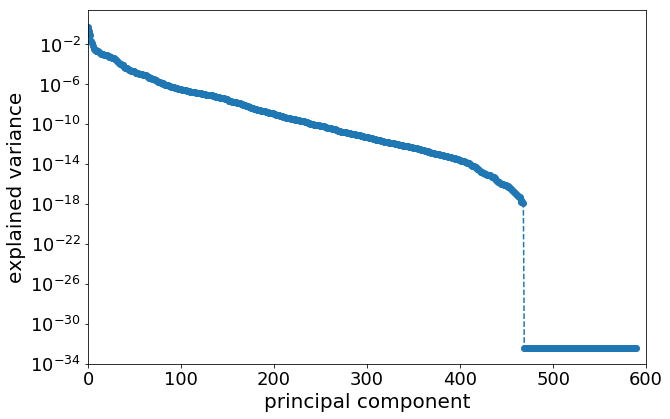

In [22]:
plt.figure(figsize = (10,6.5));
plt.semilogy(explained_variance, '--o');
plt.xlabel('principal component', fontsize = 20);
plt.ylabel('explained variance', fontsize = 20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 600]);

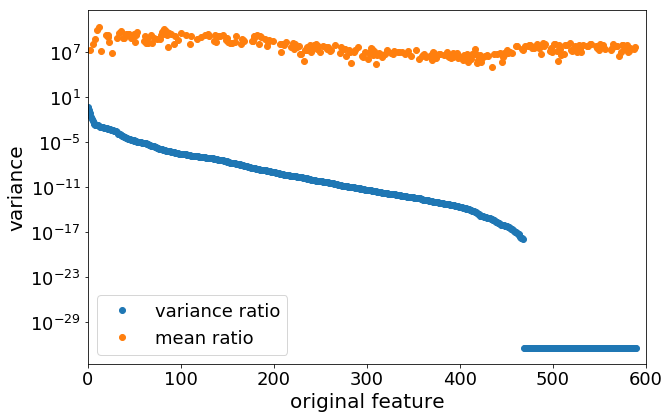

In [23]:
plt.figure(figsize = (10,6.5));
plt.semilogy(np.square(x_train.std(axis=0)) / np.square(x_train.std(axis=0)).sum(), 'o', label = 'variance ratio');
plt.semilogy(x_train.mean(axis=0) / np.square(x_train.mean(axis=0)).sum(), 'o', label = 'mean ratio');
plt.xlabel('original feature', fontsize = 20);
plt.ylabel('variance', fontsize = 20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 600]);
plt.legend(loc='lower left', fontsize=18);

## Appling PCA after scalling

## Scalling data for PCA

In [24]:
# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

 #Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_

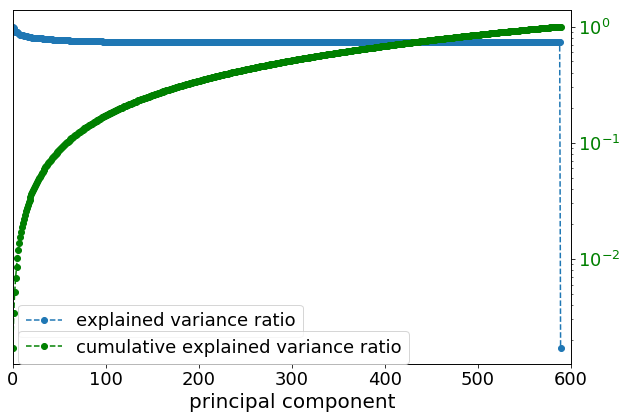

In [25]:
 fig, ax1 = plt.subplots(figsize = (10,6.5))
ax1.semilogy(explained_variance, '--o', label = 'explained variance ratio');
color =  ax1.lines[0].get_color()
ax1.set_xlabel('principal component', fontsize = 20);
#for tl in ax1.get_yticklabels():
 #   tl.set_color(plot1[0].get_color())
    
plt.legend(loc=(0.01, 0.075) ,fontsize = 18);

ax2 = ax1.twinx()
ax2.semilogy(explained_variance.cumsum(), '--go', label = 'cumulative explained variance ratio');
for tl in ax2.get_yticklabels():
    tl.set_color('g')

ax1.tick_params(axis='both', which='major', labelsize=18);
ax1.tick_params(axis='both', which='minor', labelsize=12);
ax2.tick_params(axis='both', which='major', labelsize=18);
ax2.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 600]);
plt.legend(loc=(0.01, 0),fontsize = 18);

From the graph above it is possible to see that with 4/6th i.e. 400 PC with explained 68%. Loosing only 32% of information

In [26]:
uu = explained_variance.cumsum()
print('400 PC expalined',uu[400])

400 PC expalined 0.6799761863528629


# Original features relevance

In [27]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

 #Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 400)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_

In [28]:
pca_inv_data = pca.inverse_transform(np.eye(400))

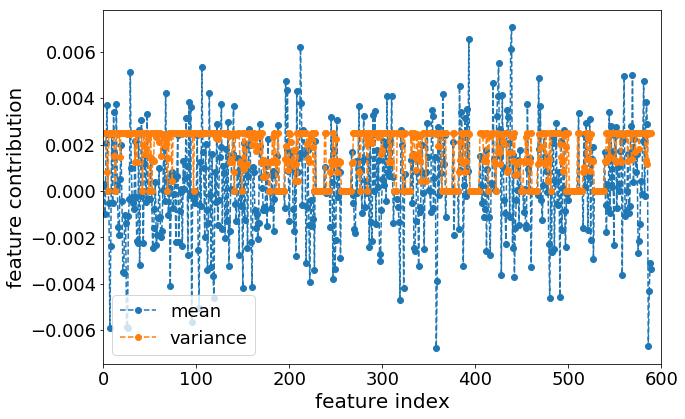

In [29]:
fig = plt.figure(figsize=(10, 6.5))
plt.plot(pca_inv_data.mean(axis=0), '--o', label = 'mean')
plt.plot(np.square(pca_inv_data.std(axis=0)), '--o', label = 'variance')
plt.legend(loc='lower right')
plt.ylabel('feature contribution', fontsize=20);
plt.xlabel('feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 600])
plt.legend(loc='lower left', fontsize=18)

Zooming in the y axis

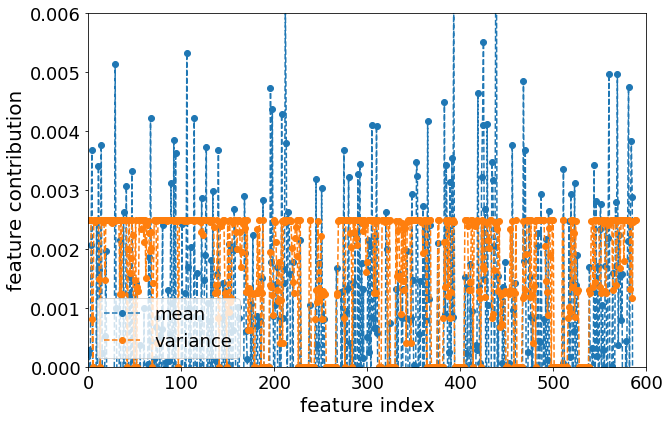

In [30]:
fig = plt.figure(figsize=(10, 6.5))
plt.plot(pca_inv_data.mean(axis=0), '--o', label = 'mean')
plt.plot(np.square(pca_inv_data.std(axis=0)), '--o', label = 'variance')
plt.legend(loc='lower right')
plt.ylabel('feature contribution', fontsize=20);
plt.xlabel('feature index', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=18);
plt.tick_params(axis='both', which='minor', labelsize=12);
plt.xlim([0, 600])
plt.ylim([0, 0.006])
plt.legend(loc='lower left', fontsize=18)

In [31]:

original_values = pd.DataFrame(data=pca_inv_data.mean(axis=0)[:])
original_values.sort_values(by=[0], ascending = False, inplace = True)
original_values.head(5)

,0
439,0.007086
393,0.006536
212,0.006183
438,0.006133
425,0.005510


# Classification Model



## Metrics for unbalanced data

Considering that were are dealing with a highly unbalanced data (6%) of positive values and we are dealing with failures of physical assets, the positive values must have enhanced importance.

Having this in mind the principal metric that must be used is the precision. Precision = TP / (TP + FP)

In addiction, it can be used the recall metric Recall =  True positives /  positives = TP / (TP+FN)

In this specific case, wi are going to look for a model that has the higher precision possible.

## Logistic Regression

In [32]:
# Fitting Logistic Regression to the Training set
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

 #Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)
accuracy = cm[0][0] / (cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1])
print('The accuracy of the model is: ',accuracy)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
mean = accuracies.mean()
print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())

print('precision score',precision_score(y_test, y_pred, average='binary'))


The cm matrix is [[444   1]
 [ 26   0]]
The accuracy of the model is:  0.9426751592356688
Accuracy mean: 0.9279461279461281
Accuracy std: 0.0045091454164025956
precision score 0.0


The logistic regression model is very bad because is unable to predict True positives. Lets try the Random forest

## Random Forest


In [33]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

 #Applying PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 400)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)
accuracy = cm[0][0] / (cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1])
print('The accuracy of the model is: ',accuracy)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 15)
mean = accuracies.mean()
print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())

print('precision score',precision_score(y_test, y_pred, average='binary'))


The cm matrix is [[443   2]
 [ 26   0]]
The accuracy of the model is:  0.940552016985138
Accuracy mean: 0.9288624240679035
Accuracy std: 0.004981854549536327
precision score 0.0


The Random Forest Model has better accuracy, but still cannot predict True Positives.

Having this two bad results, lets try a non linear model to reduce dimentions

## Kernel PCA

In [34]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

# Applying Kernel PCA
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 400, kernel = 'rbf')
x_train = kpca.fit_transform(x_train)
x_test = kpca.transform(x_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)
accuracy = cm[0][0] / (cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1])
print('The accuracy of the model is: ',accuracy)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 15)
mean = accuracies.mean()
print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())

print('precision score',precision_score(y_test, y_pred, average='binary'))


The cm matrix is [[445   0]
 [ 26   0]]
The accuracy of the model is:  0.9447983014861996
Accuracy mean: 0.9288624240679035
Accuracy std: 0.004981854549536327
precision score 0.0


/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The kernel PCA returns worst results, which first indicates that ao best model must be a linear one.

Let's then try the LDA, which is a linear model as well. I am going to use the random forest model beacause is the best until now

## LDA

In [35]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

# Applying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = None)
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)
explained_variance = lda.explained_variance_ratio_

print('explained variance', explained_variance)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)
accuracy = cm[0][0] / (cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1])
print('The accuracy of the model is: ',accuracy)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 15)
mean = accuracies.mean()
print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())

print('precision score',precision_score(y_test, y_pred, average='binary'))


/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance [1.]
The cm matrix is [[399  46]
 [ 20   6]]
The accuracy of the model is:  0.8471337579617835
Accuracy mean: 0.9680221317207619
Accuracy std: 0.02108102074465422
precision score 0.11538461538461539


This models returns a warning because are variables in the model that are almost colinear. This happens due the matrix within the model that has a determinat almost = 0

Lets não try to improve this model using SVM 

## LDA with SVM

In [36]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

# Applying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = None)
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)
explained_variance = lda.explained_variance_ratio_

print('explained variance', explained_variance)

# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)
accuracy = cm[0][0] / (cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1])
print('The accuracy of the model is: ',accuracy)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 15)
mean = accuracies.mean()
print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())

print('precision score',precision_score(y_test, y_pred, average='binary'))

explained variance [1.]
The cm matrix is [[405  40]
 [ 19   7]]
The accuracy of the model is:  0.8598726114649682
Accuracy mean: 0.9844865413358564
Accuracy std: 0.015713731818874095
precision score 0.14893617021276595


/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The LDA with the SVM return better results, then lets try improve this model with grid search

## LDA + SVM with grid Search (BEST RESULT!!!!! )

In [37]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

# Applying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 400)
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(x_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
mean = accuracies.mean()
print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())

print('precision score',precision_score(y_test, y_pred, average='binary'))


# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear'], 'gamma': [0.00000001,0.0002,0.0003,0.0004,0.005,0.006,0.007,0.008,0.009,0.01]},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)
grid_search = grid_search.fit(x_train, y_train)
best_accuracy = grid_search.best_score_
print('best accuracy is:',best_accuracy )
best_parameters = grid_search.best_params_
print('best parameters are:',best_parameters)

/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The cm matrix is [[405  40]
 [ 19   7]]
Accuracy mean: 0.9845117845117844
Accuracy std: 0.013498912366653407
precision score 0.14893617021276595
best accuracy is: 0.9854014598540146
best parameters are: {'C': 10, 'gamma': 1e-08, 'kernel': 'linear'}


With the grid search we can see clearly that the linear model is best suitable for this model. 

The default C values is correct.
After having tryed several values for the gamma parameter, I conclude that the default values is good 1 / nfetaures


# How to deal with unbalanced data

Has seen before, our data is very unbalanced (6% positives).  In order to try solve this problem, I am going to over sample the minory class.

To implement this I am going to use the SMOTE algorith:
- Finds the k-nearest-neighbors for minority class;
- Randomly chooses one of the k-nearest-neighbors and using it to create a similar

In order to correctly oversample data, we must perform this operation only on training data. By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable.

## LDA with SVM + SMOTE

In [38]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

    # Apply the SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 0.3, kind= 'regular')
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

# Applying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 400)
x_train = lda.fit_transform(x_train_res, y_train_res)
x_test = lda.transform(x_test)

# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(x_train, y_train_res)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)
accuracy = cm[0][0] / (cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1])
print('The accuracy of the model is: ',accuracy)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 10)
mean = accuracies.mean()

print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())
print('precision score',precision_score(y_test, y_pred, average='binary')) # our dependent variable is binary


/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The cm matrix is [[404  41]
 [ 19   7]]
The accuracy of the model is:  0.8577494692144374
Accuracy mean: 0.9176960878949629
Accuracy std: 0.030350299442007143
precision score 0.14583333333333334


This solution is very interesting because the  precision worst. I was expecting exactly the opposite. 

The explanation is due to the fact that applying SMOTE, we increase the risk of over fitting.

In order to prevent this to happen, must be used the random forest algorithm because his properties reduce this effect

## LDA with Random Forest + SMOTE

In [39]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train)
x_test = sc_X.transform(x_test)

    # Apply the SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 0.3)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

# Applying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = None)
x_train = lda.fit_transform(x_train_res, y_train_res)
x_test = lda.transform(x_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 15, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train_res)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)
accuracy = cm[0][0] / (cm[0][0] + cm[1][0] + cm[0][1] + cm[1][1])
print('The accuracy of the model is: ',accuracy)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train_res, y = y_train_res, cv = 10)
mean = accuracies.mean()

print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())
print('precision score',precision_score(y_test, y_pred, average='binary'))


/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The cm matrix is [[405  40]
 [ 20   6]]
The accuracy of the model is:  0.8598726114649682
Accuracy mean: 0.93891486175536
Accuracy std: 0.039617653914842406
precision score 0.13043478260869565


## LDA with xgboost+ SMOTE



In [40]:
#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.4, random_state = 0)
print("x_train size before smote",sum(y_train), len(y_train))
 # Apply the SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12, ratio = 1)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)
print("x_train size after smote",sum(y_train_res), len(y_train_res))

# Scaling data
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
x_train = sc_X.fit_transform(x_train_res)
x_test = sc_X.transform(x_test)

# Applying LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components = 400)
x_train = lda.fit_transform(x_train, y_train_res)
x_test = lda.transform(x_test)

# Fitting XGBOOST to the Training set
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(x_train, y_train_res)

# Predicting the Test set results
y_pred = classifier.predict(x_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print('The cm matrix is',cm)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train_res, cv = 10)
mean = accuracies.mean()

print('Accuracy mean:',mean)
print('Accuracy std:',accuracies.std())

print('precision score',precision_score(y_test, y_pred, average = 'binary'))




x_train size before smote 69 940
x_train size after smote 871 1742


/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The cm matrix is [[551  41]
 [ 28   7]]
Accuracy mean: 0.9982823928944619
Accuracy std: 0.003672862171150791
precision score 0.14583333333333334


/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/tiagocabo/anaconda3/envs/Py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: De